# Restricted Boltzmann Machine

## Importing Libraries

In [27]:
import cv2
import random
import numpy as np
import tensorflow as tf
from tqdm.notebook import tqdm, trange
from skimage.transform import rotate, AffineTransform, warp

from sklearn import datasets
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import BernoulliRBM
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
%matplotlib inline

## Loading Dataset

### Using Sklearn

In [28]:
# dataset = datasets.fetch_openml(name='mnist_784', version='active', cache=True)
# print(dataset.data.shape)
# print(dataset.target.shape)

# (trainX, testX, trainY, testY) = train_test_split(dataset.data, dataset.target.astype("int0"), test_size = 0.33)

### Using TensorFlow

In [29]:
(training_images, training_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

## Analyzing Dataset

Random 25 Images from the Training Data:


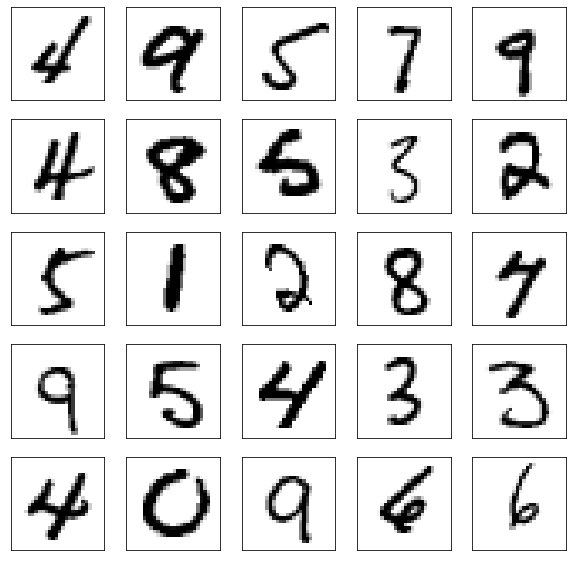

In [30]:
print("Random 25 Images from the Training Data:")
plt.figure(figsize=(10, 10))
for i in range(25):
    rand_image_idx = np.random.randint(0, training_labels.shape[0])
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid('off')
    plt.imshow(training_images[rand_image_idx], cmap=plt.cm.binary)

In [31]:
print('Shape of training set:', training_images.shape)
print('Shape of test set:', training_images.shape)

Shape of training set: (60000, 28, 28)
Shape of test set: (60000, 28, 28)


## Preparing Data

### Data Augmentation

In [32]:
def rotate_image(img):
    return rotate(image=img, angle=random.randint(a=-45, b=45), resize=False, center=None, clip=True, mode='constant', preserve_range=True)

In [33]:
def shift_image(img):
    return warp(image=img, inverse_map=AffineTransform(translation=(random.randint(a=-5, b=5), random.randint(a=-2, b=2))), 
                mode='constant', clip=True, preserve_range=True)

In [34]:
def blur_image(img):
    n = random.randrange(start=3, stop=9, step=2)
    return cv2.GaussianBlur(src=img, ksize=(n, n), sigmaX=0, sigmaY=0)

In [35]:
transformations = {
    'rotate': rotate_image,
    'shift': shift_image,
    'blur': blur_image
}

In [36]:
x_train, y_train = [], []
for image, label in tqdm(zip(training_images, training_labels), desc='Progress', total=training_images.shape[0]):
    # choose random number of transformations to apply on the image
    transformation_count = random.randint(a=1, b=len(transformations))

    for _ in range(transformation_count):
        # choose random transformation
        key = random.choice(seq=list(transformations))

        x_train.append(transformations[key](image))
        y_train.append(label)

training_images, training_labels = np.array(x_train, dtype='uint8'), np.array(y_train, dtype='uint8')

### Normalizing Data

In [37]:
training_images = training_images/255.
test_images = test_images/255.

### Flattening Out

In [38]:
flatten_training_images = training_images.reshape((training_images.shape[0], -1))
flatten_test_images = test_images.reshape((test_images.shape[0], -1))

## Model Approach

### Using Sklearn's BernoulliRBM + LogisticRegression

+ https://scikit-learn.org/stable/modules/neural_networks_unsupervised.html

#### Initializing Models

In [ ]:
# BernoulliRBM
rbm = BernoulliRBM(n_components=256, learning_rate=0.1, batch_size=10, n_iter=10, verbose=1, random_state=None)

# LogisticRegression
logistic = LogisticRegression(penalty='l2', dual=False, tol=1e-4, C=1.0, fit_intercept=True, intercept_scaling=1, class_weight=None, 
                              random_state=None, solver='lbfgs', max_iter=100, multi_class='auto', verbose=1, warm_start=False, n_jobs=-1, l1_ratio=None)

# Creating Pipeline of events
classifier = Pipeline(steps=[('rbm', rbm), ('logistic', logistic)], memory=None, verbose=1)

#### Fitting Model

In [ ]:
classifier.fit(X=flatten_training_images, y=training_labels)

[BernoulliRBM] Iteration 1, pseudo-likelihood = -116.19, time = 67.78s
[BernoulliRBM] Iteration 2, pseudo-likelihood = -114.76, time = 75.16s
[BernoulliRBM] Iteration 3, pseudo-likelihood = -111.63, time = 75.08s
[BernoulliRBM] Iteration 4, pseudo-likelihood = -113.28, time = 74.72s
[BernoulliRBM] Iteration 5, pseudo-likelihood = -111.93, time = 74.48s
[BernoulliRBM] Iteration 6, pseudo-likelihood = -110.93, time = 74.65s
[BernoulliRBM] Iteration 7, pseudo-likelihood = -111.02, time = 75.41s
[BernoulliRBM] Iteration 8, pseudo-likelihood = -109.46, time = 74.90s
[BernoulliRBM] Iteration 9, pseudo-likelihood = -112.37, time = 75.00s
[BernoulliRBM] Iteration 10, pseudo-likelihood = -111.66, time = 75.08s
[Pipeline] ............... (step 1 of 2) Processing rbm, total=12.5min


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


[Pipeline] .......... (step 2 of 2) Processing logistic, total=  37.7s


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   37.5s finished


Pipeline(memory=None,
         steps=[('rbm',
                 BernoulliRBM(batch_size=10, learning_rate=0.1,
                              n_components=256, n_iter=10, random_state=None,
                              verbose=1)),
                ('logistic',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=-1, penalty='l2',
                                    random_state=None, solver='lbfgs',
                                    tol=0.0001, verbose=1, warm_start=False))],
         verbose=1)

#### Analyzing Results

#### Training-Set

In [ ]:
print(classification_report(y_true=training_labels, y_pred=classifier.predict(X=flatten_training_images), labels=None, target_names=None, 
                            digits=2, output_dict=False, zero_division='warn'))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92     11864
           1       0.95      0.97      0.96     13487
           2       0.87      0.85      0.86     12003
           3       0.83      0.82      0.83     12236
           4       0.87      0.80      0.83     11739
           5       0.82      0.79      0.80     10922
           6       0.90      0.91      0.90     11903
           7       0.90      0.84      0.87     12510
           8       0.74      0.81      0.77     11570
           9       0.77      0.84      0.80     11866

    accuracy                           0.86    120100
   macro avg       0.86      0.85      0.85    120100
weighted avg       0.86      0.86      0.86    120100



#### Test-Set

In [ ]:
print(classification_report(y_true=test_labels, y_pred=classifier.predict(X=flatten_test_images), labels=None, target_names=None, 
                            digits=2, output_dict=False, zero_division='warn'))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       980
           1       0.96      0.99      0.98      1135
           2       0.94      0.92      0.93      1032
           3       0.93      0.92      0.93      1010
           4       0.94      0.92      0.93       982
           5       0.89      0.92      0.90       892
           6       0.94      0.97      0.95       958
           7       0.94      0.91      0.92      1028
           8       0.93      0.84      0.88       974
           9       0.87      0.91      0.89      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



#### GridSearch HyperParameters

In [ ]:
# params = {
#     'rbm__learning_rate': [0.1, 0.01, 0.001],
# 	'rbm__n_iter': [20, 40, 80],
#     'rbm__n_components': [50, 100, 200],
# 	'logistic__C': [1.0, 10.0, 100.0]
# }

# # perform a grid search over the parameter
# gs = GridSearchCV(estimator=classifier, param_grid=params, scoring=None, error_score=np.nan, n_jobs=-1, verbose=1)
# gs.fit(flatten_training_images, training_labels)
# gs.best_estimator_.get_params()

### Using PyDBM's DeepBoltzmannMachine

+ https://code.accel-brain.com/Deep-Learning-by-means-of-Design-Pattern/README.html

#### Loading Library

In [ ]:
!pip install pydbm -q

     |████████████████████████████████| 6.9MB 3.2MB/s 


In [ ]:
# The `Client` in Builder Pattern
from pydbm.dbm.deep_boltzmann_machine import DeepBoltzmannMachine

# The `Concrete Builder` in Builder Pattern.
from pydbm.dbm.builders.dbm_multi_layer_builder import DBMMultiLayerBuilder

# Contrastive Divergence for function approximation.
from pydbm.approximation.contrastive_divergence import ContrastiveDivergence

In [ ]:
# Logistic Function as activation function.
from pydbm.activation.logistic_function import LogisticFunction

# Tanh Function as activation function.
from pydbm.activation.tanh_function import TanhFunction

# ReLu Function as activation function.
from pydbm.activation.relu_function import ReLuFunction

In [ ]:
# Adam as a optimizer.
from pydbm.optimization.optparams.adam import Adam

# is-a `OptParams`.
opt_params = Adam(
    # BETA 1.
    beta_1=0.9,
    
    # BETA 2.
    beta_2=0.99
)

In [ ]:
# Regularization for weights matrix
# to repeat multiplying the weights matrix and `0.9`
# until $\sum_{j=0}^{n}w_{ji}^2 < weight\_limit$.
opt_params.weight_limit = 1e+03

# Probability of dropout.
opt_params.dropout_rate = 0.5

In [ ]:
# Contrastive Divergence for visible layer and first hidden layer.
first_cd = ContrastiveDivergence(opt_params=opt_params)

# Contrastive Divergence for first hidden layer and second hidden layer.
second_cd = ContrastiveDivergence(opt_params=opt_params)

#### Initializing Model

In [ ]:
# DBM
dbm = DeepBoltzmannMachine(
    # `Concrete Builder` in Builder Pattern,
    # which composes three restricted boltzmann machines for building a deep boltzmann machine.
    DBMMultiLayerBuilder(),

    # Dimention in visible layer, hidden layer, and second hidden layer.
    [flatten_training_images.shape[1], 14, flatten_training_images.shape[1]],

    # Setting objects for activation function.
    [ReLuFunction(), LogisticFunction(), TanhFunction()],

    # Setting the object for function approximation.
    [first_cd, second_cd], 

    # Setting learning rate.
    learning_rate=0.05
)

#### Fitting Model

+ The below code doesn't work as flatten_training_images[i].shape should be (n, 1), but it is instead (n, ) & hence probably throws error.

In [ ]:
# # Execute learning.
# dbm.learn(
#     # `np.ndarray` of observed data points.
#     flatten_training_images,

#      # If approximation is the Contrastive Divergence, this parameter is `k` in CD method.
#     training_count=1,

#     # Batch size in mini-batch training.
#     batch_size=200,

#     # if `r_batch_size` > 0, the function of `dbm.learn` is a kind of reccursive learning.
#     r_batch_size=-1 
# )